### Model Building & Training (Transfer Learning)

In [1]:
# Import Libraries

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# Load Preprocessed Data 

dataset_path = "COVID-19_Radiography_Dataset"

# Reuse same preprocessing config
img_height, img_width = 224, 224
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [3]:
# Load ResNet50 Pretrained Model (Transfer Learning)

base_model = ResNet50(
    weights='imagenet',    # Pretrained on ImageNet
    include_top=False,     # Remove top classification layers
    input_shape=(img_height, img_width, 3)
)

# Freeze Base Model Layers (for Transfer Learning Stage 1)
base_model.trainable = False

In [4]:
# Add Custom Classification Layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
# Compile Model

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
# Model Callbacks (Checkpoint & EarlyStopping)

checkpoint = ModelCheckpoint(
    "best_model_resnet50.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [7]:
# Train Model

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/15
530/530 [==============================] - ETA: 0s - loss: 1.2200 - accuracy: 0.4631     
Epoch 1: val_accuracy improved from -inf to 0.48157, saving model to best_model_resnet50.h5
530/530 [==============================] - 2944s 6s/step - loss: 1.2200 - accuracy: 0.4631 - val_loss: 1.1583 - val_accuracy: 0.4816
Epoch 2/15
530/530 [==============================] - ETA: 0s - loss: 1.1734 - accuracy: 0.4885   
Epoch 2: val_accuracy did not improve from 0.48157
530/530 [==============================] - 3338s 6s/step - loss: 1.1734 - accuracy: 0.4885 - val_loss: 1.1336 - val_accuracy: 0.4816
Epoch 3/15
530/530 [==============================] - ETA: 0s - loss: 1.1512 - accuracy: 0.4983     
Epoch 3: val_accuracy did not improve from 0.48157
530/530 [==============================] - 3295s 6s/step - loss: 1.1512 - accuracy: 0.4983 - val_loss: 1.1184 - val_accuracy: 0.4816
Epoch 4/15
530/530 [==============================] - ETA: 0s - loss: 1.1342 - accuracy: 0.5123   
Epoch 4

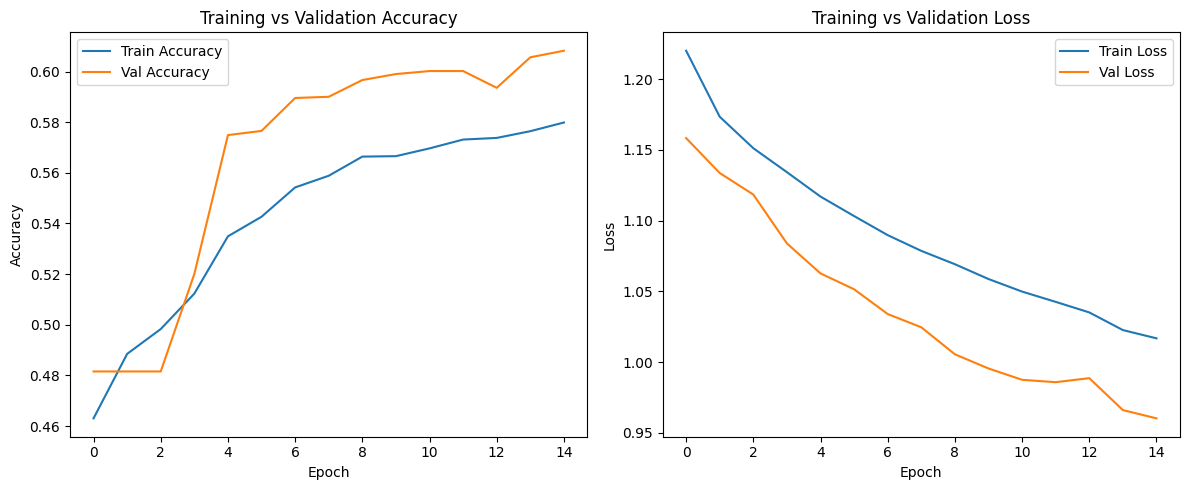

In [8]:
# Visualize Training & Validation Metrics

import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Evaluation Metrics

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Get true labels & predictions
val_generator.reset()
Y_true = val_generator.classes
Y_pred_prob = model.predict(val_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Class labels
class_labels = list(val_generator.class_indices.keys())

133/133 [==============================] - 528s 4s/step


In [10]:
# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(Y_true, Y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# AUC Score (macro-average across classes)
try:
    auc = roc_auc_score(tf.keras.utils.to_categorical(Y_true), Y_pred_prob, multi_class='ovo', average='macro')
    print(f"AUC Score (macro): {auc:.4f}")
except Exception as e:
    print("AUC Score could not be computed:", str(e))

Confusion Matrix:
 [[   0  402  321    0]
 [   0  874  328    0]
 [   0  338 1700    0]
 [   0   45  224    0]]
Classification Report:
                  precision    recall  f1-score   support

          COVID       0.00      0.00      0.00       723
   Lung_Opacity       0.53      0.73      0.61      1202
         Normal       0.66      0.83      0.74      2038
Viral Pneumonia       0.00      0.00      0.00       269

       accuracy                           0.61      4232
      macro avg       0.30      0.39      0.34      4232
   weighted avg       0.47      0.61      0.53      4232

AUC Score (macro): 0.8274


C:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [11]:
# Fine-Tuning + Class Weights

# Step 1: Unfreeze Top ResNet50 Layers
# Unfreeze last 75 layers of ResNet50 for fine-tuning:


base_model.trainable = True

# Freeze the first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

In [12]:
# Step 2: Recompile the Model with Lower Learning Rate
# Fine-tuning requires a smaller learning rate to avoid destroying pretrained weights:

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),   # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Step 3: Compute Class Weights

from sklearn.utils import class_weight
import numpy as np

# Compute class weights based on training data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary format
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Convert to dictionary format
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.4632734185966125, 1: 0.8800935550935551, 2: 0.5191623742948246, 3: 3.9342472118959106}
Class Weights: {0: 1.4632734185966125, 1: 0.8800935550935551, 2: 0.5191623742948246, 3: 3.9342472118959106}


In [14]:
# Step 4: Fine-tune the Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_model_finetuned.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Fine-tune for 5–10 more epochs
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,  # <--- key step
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10
530/530 [==============================] - ETA: 0s - loss: 0.7198 - accuracy: 0.6636     
Epoch 1: val_accuracy improved from -inf to 0.67509, saving model to best_model_finetuned.h5
530/530 [==============================] - 4747s 9s/step - loss: 0.7198 - accuracy: 0.6636 - val_loss: 0.7816 - val_accuracy: 0.6751
Epoch 2/10
530/530 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.7747     
Epoch 2: val_accuracy did not improve from 0.67509
530/530 [==============================] - 4712s 9s/step - loss: 0.4743 - accuracy: 0.7747 - val_loss: 1.0158 - val_accuracy: 0.6151
Epoch 3/10
530/530 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.8081     
Epoch 3: val_accuracy improved from 0.67509 to 0.75402, saving model to best_model_finetuned.h5
530/530 [==============================] - 4723s 9s/step - loss: 0.4055 - accuracy: 0.8081 - val_loss: 0.6319 - val_accuracy: 0.7540
Epoch 4/10
530/530 [==============================] - ETA:

In [15]:
# Save Final Fine-Tuned Model

model.save("final_resnet50_finetuned.h5")

In [16]:
# Re-Evaluate the Fine-Tuned Model

# Let’s now run a new classification report and confusion matrix using the best fine-tuned model to confirm improvement across all 4 classes.

# Step 1: Load the Fine-tuned Best Model

from tensorflow.keras.models import load_model

# Load best fine-tuned weights
model = load_model("best_model_finetuned.h5")

In [17]:
# Step 2: Predict and Evaluate

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Get true labels and predicted probabilities
val_generator.reset()
Y_true = val_generator.classes
Y_pred_prob = model.predict(val_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Class names from generator
class_labels = list(val_generator.class_indices.keys())

133/133 [==============================] - 837s 6s/step


In [18]:
# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(Y_true, Y_pred, target_names=class_labels, zero_division=0))

# AUC Score (macro average)
try:
    auc = roc_auc_score(tf.keras.utils.to_categorical(Y_true), Y_pred_prob, multi_class='ovo', average='macro')
    print(f"AUC Score (macro): {auc:.4f}")
except Exception as e:
    print("AUC Score could not be computed:", str(e))

Confusion Matrix:
 [[ 633   42   47    1]
 [  38  987  177    0]
 [  65  109 1847   17]
 [   8    8   22  231]]
Classification Report:
                  precision    recall  f1-score   support

          COVID       0.85      0.88      0.86       723
   Lung_Opacity       0.86      0.82      0.84      1202
         Normal       0.88      0.91      0.89      2038
Viral Pneumonia       0.93      0.86      0.89       269

       accuracy                           0.87      4232
      macro avg       0.88      0.87      0.87      4232
   weighted avg       0.87      0.87      0.87      4232

AUC Score (macro): 0.9750


In [19]:
# Save Final Fine-Tuned Model

model.save("final_resnet50_finetuned.h5")